In [1]:
import gensim
import pandas as pd

In [2]:
corpus_cleaned = pd.read_csv("corpus_lemtokenized.csv", header=None)

In [3]:
import re

def tokenize(text):
    tokens = re.split('\s+', text)
    tokens_decoded_lowered = []
    for word in tokens:
        tokens_decoded_lowered.append(word.decode("utf-8"))
    return tokens_decoded_lowered

In [4]:
doc_series = corpus_cleaned[1].apply(tokenize)

In [5]:
doc_series.head()

0    [премьерминистр, россия, владимир, путин, дать...
1    [казахстанский, горнорудный, корпорация, enrc,...
2    [костанай, частный, предприниматель, привлечь,...
3    [мажилиса, одобрить, закон, фонд, национальный...
4    [генеральный, директор, холдинг, нурмедиа, арм...
Name: 1, dtype: object

In [6]:
documents = doc_series.values.tolist()

model = gensim.models.Word2Vec(
    documents,
    size=200,
    window=10,
    min_count=5,
    workers=10)
model.train(documents, total_examples=len(documents), epochs=10)

(66744627, 69887100)

In [7]:
from nltk.cluster import KMeansClusterer
import nltk

In [8]:
X = model[model.wv.vocab]

/home/dauken/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [9]:
vocab_dict = dict(zip(list(model.wv.vocab), X.tolist()))

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [12]:
import numpy as np

In [13]:
f = open("output_facts_v4.csv")
facts = f.readlines()
f.close()

In [14]:
facts = list(facts)

In [15]:
facts = [line.decode("utf-8") for line in facts]
facts_series = pd.Series(facts)

In [16]:
facts_series.head()

0    "согласиться, маттиас","сообщать, &s","войти, ...
1    "найти, житель","произойти, инцидент","упасть,...
2    "подвергнуться, сайт","украсть, дать","достигн...
3    "обвиняться, &s","сообщать, риа","арестовать, ...
4    "надеяться, наставник","задержаться, полузащит...
dtype: object

In [17]:
facts_series = facts_series.apply(lambda x: re.findall('"([^"]*)"', x))

In [18]:
facts_df = facts_series.apply(lambda x: [re.findall(ur'(?u)\w+', item) for item in x]).to_frame('facts_list')

In [19]:
facts_df['root'] = facts_df.facts_list.apply(lambda x: [item[0] for item in x if (len(item) == 2) and ('s' not in item)])

In [20]:
facts_df['obj'] = facts_df.facts_list.apply(lambda x: [item[1] for item in x if (len(item) == 2) and ('s' not in item)])

In [21]:
facts_df.head()

,facts_list,root,obj
0,"[[согласиться, маттиас], [сообщать, s], [войти...","[согласиться, появиться, претендовать, мочь, к...","[маттиас, список, варнига, он, представитель, ..."
1,"[[найти, житель], [произойти, инцидент], [упас...","[найти, произойти, упасть, побояться, упасть, ...","[житель, инцидент, шар, мы, они, материал, он,..."
2,"[[подвергнуться, сайт], [украсть, дать], [дост...","[подвергнуться, украсть, достигнуть, посоветов...","[сайт, дать, число, руководство, это, информация]"
3,"[[обвиняться, s], [сообщать, риа], [арестовать...","[сообщать, находиться, идти, получить, подозре...","[риа, архимандрит, расследование, полиция, обв..."
4,"[[надеяться, наставник], [задержаться, полузащ...","[надеяться, задержаться, возможно, знать, хоте...","[наставник, полузащитник, весь, бекхэма, мы, о..."


In [130]:
for word in facts_df.loc[1134, 'obj']:
    print word

уровень
показатель
это
спам
сеть
источник
ботсеть
лидерство


In [164]:
def get_similar_texts(input_txt_objs, all_txts):
    bool_obj = all_txts.obj.apply(lambda x: len([item for item in input_txt_objs if item in x]) > 0)
    return all_txts[bool_obj]

In [215]:
similar = get_similar_texts(["аблязов".decode("utf-8"), "джакишев".decode("utf-8")], facts_df)

In [216]:
len(similar)

108

In [217]:
def get_all_facts(texts):
    vocab_root = []
    vocab_obj = []
    vocab_root = [item for lst in texts.root for item in lst]
    vocab_obj = [item for lst in texts.obj for item in lst]
    vocab_facts = pd.DataFrame({
        'root': vocab_root,
        'obj': vocab_obj
    },
        columns = ['root', 'obj']
    )
    vocab_facts['root_vector'] = vocab_facts['root'].apply(lambda x: vocab_dict[x] if x in vocab_dict else None)
    vocab_facts['obj_vector'] = vocab_facts['obj'].apply(lambda x: vocab_dict[x] if x in vocab_dict else None) 
    return vocab_facts

In [238]:
vocab_facts = get_all_facts(facts_df)

In [239]:
len(vocab_facts)

483960

In [240]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

def mean(a):
    return sum(a) / len(a)

def sort_by_clustering(vocab, t, clstr_numb, init_numb):
    t
    t_vector = t + "_vector"
    sorted_vocab = vocab_facts[[t, t_vector]]
    sorted_vocab = sorted_vocab.drop_duplicates(subset = t)
    sorted_vocab = sorted_vocab[sorted_vocab[t_vector].notnull()]
    sorted_vocab = sorted_vocab.reset_index(drop=True)
    X_t = sorted_vocab[t_vector].tolist()
    kmeans = KMeans(n_clusters=clstr_numb, n_init=init_numb)  
    kmeans.fit(X_t)
    assigned_clusters = kmeans.labels_
    sorted_vocab['cluster_numb'] = pd.Series(assigned_clusters)
    centers = kmeans.cluster_centers_
    sorted_vocab["cluster_center"] = sorted_vocab.cluster_numb.apply(lambda x: centers[x])
    sorted_vocab['cosine_word2centroid'] = sorted_vocab.apply(lambda x: 1 - cosine(x[t_vector], x["cluster_center"]), axis=1)
    center_of_centroids = map(mean, zip(*centers))
    sorted_vocab['cosine_center2centroid'] = sorted_vocab.apply(lambda x: 1 - cosine(x["cluster_center"], center_of_centroids), axis=1)
    sorted_vocab = sorted_vocab.sort_values(by = ['cosine_center2centroid','cosine_word2centroid'], ascending=False)
    sorted_vocab = sorted_vocab.reset_index(drop=True)
    return sorted_vocab

In [241]:
from sklearn.cluster import DBSCAN

def mean(a):
    return sum(a) / len(a)

def sort_by_clustering_db(vocab, t):
    t
    t_vector = t + "_vector"
    sorted_vocab = vocab_facts[[t, t_vector]]
    sorted_vocab = sorted_vocab.drop_duplicates(subset = t)
    sorted_vocab = sorted_vocab[sorted_vocab[t_vector].notnull()]
    sorted_vocab = sorted_vocab.reset_index(drop=True)
    X_t = sorted_vocab[t_vector].tolist()
    dbscan = DBSCAN(eps=11, min_samples=4, metric='euclidean', n_jobs = 2).fit(X_t)  
    assigned_clusters = dbscan.labels_
    sorted_vocab['cluster_numb'] = pd.Series(assigned_clusters)
    return sorted_vocab

In [37]:
DBSCAN?

In [242]:
sorted_vocab_root = sort_by_clustering(vocab_facts, "root", 70, 50)
sorted_vocab_obj = sort_by_clustering(vocab_facts, "obj", 70, 100)

In [222]:
sorted_vocab_root['root_order'] = sorted_vocab_root.index.values
sorted_vocab_obj['obj_order'] = sorted_vocab_obj.index.values

In [223]:
sorted_vocab_obj.head()

,obj,obj_vector,cluster_numb,cluster_center,cosine_word2centroid,cosine_center2centroid,obj_order
0,правительство,"[-1.55585753918, 4.34938383102, 0.557132422924...",41,"[0.21177388895668237, -0.8443638223278173, 0.6...",0.545269,0.731485,0
1,аблязов,"[0.039946321398, -3.45129704475, -0.8238002061...",41,"[0.21177388895668237, -0.8443638223278173, 0.6...",0.530310,0.731485,1
2,власть,"[0.50090867281, 1.11254942417, 1.27459204197, ...",41,"[0.21177388895668237, -0.8443638223278173, 0.6...",0.499778,0.731485,2
3,приватизация,"[-0.563440382481, -0.943519353867, 1.584248185...",41,"[0.21177388895668237, -0.8443638223278173, 0.6...",0.496313,0.731485,3
4,банкир,"[1.19995963573, -1.80574405193, -0.22686281800...",41,"[0.21177388895668237, -0.8443638223278173, 0.6...",0.473698,0.731485,4


In [224]:
vocab_facts_labeled = pd.merge(vocab_facts, sorted_vocab_root[['root', 'root_order']], how='inner', on=['root'])

In [225]:
vocab_facts_labeled = pd.merge(vocab_facts_labeled, sorted_vocab_obj[['obj', 'obj_order']], how='inner', on=['obj'])

In [226]:
len(vocab_facts_labeled)

1467

In [227]:
def assign_clusters(vocab, clstr_numb, init_numb):  
    vocab['fact_vector'] = vocab.apply(lambda x: [x.root_order, x.obj_order], axis=1)
    X_t = vocab["fact_vector"].tolist()
    kmeans = KMeans(n_clusters=clstr_numb, n_init=init_numb)  
    kmeans.fit(X_t)
    assigned_clusters = kmeans.labels_
    vocab['fact_cluster_numb'] = pd.Series(assigned_clusters)
    return vocab

In [234]:
facts_clustered = assign_clusters(vocab_facts_labeled, 70, 50)

In [243]:
facts_clustered[facts_clustered.fact_cluster_numb == 20]

,root,obj,root_vector,obj_vector,root_order,obj_order,fact_vector,fact_cluster_numb
229,сообщить,аблязов,"[-0.936387240887, 3.59801197052, -0.9020364880...","[0.039946321398, -3.45129704475, -0.8238002061...",369,1,"[369, 1]",20
238,задержать,аблязов,"[1.24610197544, 0.0451795049012, 0.48554080724...","[0.039946321398, -3.45129704475, -0.8238002061...",358,1,"[358, 1]",20
239,задержать,аблязов,"[1.24610197544, 0.0451795049012, 0.48554080724...","[0.039946321398, -3.45129704475, -0.8238002061...",358,1,"[358, 1]",20
240,задержать,аблязов,"[1.24610197544, 0.0451795049012, 0.48554080724...","[0.039946321398, -3.45129704475, -0.8238002061...",358,1,"[358, 1]",20
243,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20
244,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20
245,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20
246,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20
247,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20
248,арестовать,аблязов,"[1.22186934948, -0.489561527967, -2.4353072643...","[0.039946321398, -3.45129704475, -0.8238002061...",355,1,"[355, 1]",20


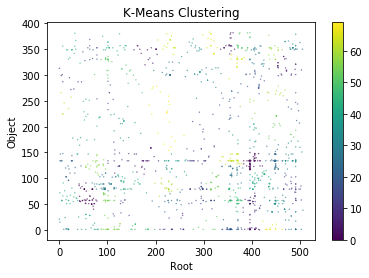

In [237]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(vocab_facts_labeled.root_order, vocab_facts_labeled.obj_order, c=vocab_facts_labeled.fact_cluster_numb,s=0.1)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Root')
ax.set_ylabel('Object')
plt.colorbar(scatter)

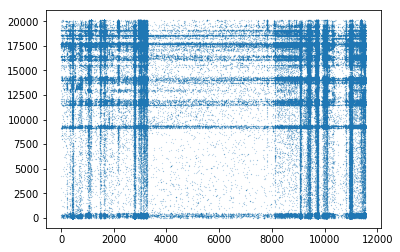

In [125]:
import matplotlib.pyplot as plt
plt.scatter(vocab_facts_labeled.root_order, vocab_facts_labeled.obj_order, s=0.01)
plt.show()